In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier



In [2]:
train = pd.read_csv("/content/train_c.csv")
test = pd.read_csv("/content/test_c.csv")
example = pd.read_csv("/content/ex_c.csv")

print(train.columns.tolist())
print("train shape:", train.shape)
print("test shape:", test.shape)

['ApplicationDate', 'Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'MaritalStatus', 'NumberOfDependents', 'HomeOwnershipStatus', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'LoanPurpose', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'EmploymentStatus', 'EducationLevel', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved']
train shape: (3446, 35)
test shape: (3914, 35)


In [3]:
TARGET_COL = "LoanApproved"

In [4]:
train_clean = train.drop_duplicates()
train_clean = train_clean.dropna(subset=["LoanApproved"]).reset_index(drop=True)

y = train_clean["LoanApproved"].astype(int).values


train_features = train_clean.drop(columns=["LoanApproved"])
test_features = test.copy()


full = pd.concat([train_features, test_features], axis=0, ignore_index=True)

print("Форма full до предобработки:", full.shape)


Форма full до предобработки: (7359, 35)


In [5]:
if "ApplicationDate" in full.columns:
    full["ApplicationDate"] = pd.to_datetime(full["ApplicationDate"], errors="coerce")

    median_ts = full["ApplicationDate"].dropna().astype("int64").median()
    median_date = pd.to_datetime(median_ts)

    full["ApplicationDate"] = full["ApplicationDate"].fillna(median_date)

    full["ApplicationMonth"] = full["ApplicationDate"].dt.month
    full["ApplicationWeekday"] = full["ApplicationDate"].dt.weekday
    first_date = full["ApplicationDate"].min()
    full["DaysSinceStart"] = (full["ApplicationDate"] - first_date).dt.days

    full = full.drop(columns=["ApplicationDate"])

print("После обработки ApplicationDate, форма full:", full.shape)


После обработки ApplicationDate, форма full: (7359, 37)


In [6]:
from sklearn.impute import KNNImputer

num_cols = full.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = full.select_dtypes(include=["object", "category"]).columns.tolist()

cat_maps = {}
full_cat_codes = pd.DataFrame(index=full.index)

for col in cat_cols:
    codes, uniques = pd.factorize(full[col], sort=True)
    full_cat_codes[col] = codes.astype(float)  # -1 = NaN
    cat_maps[col] = uniques

knn_input = pd.concat([full[num_cols].copy(), full_cat_codes], axis=1)

imputer = KNNImputer(n_neighbors=5, weights="uniform")
knn_imputed = pd.DataFrame(
    imputer.fit_transform(knn_input),
    columns=knn_input.columns,
    index=full.index
)

for col in num_cols:
    full[col] = knn_imputed[col]

for col in cat_cols:
    uniques = cat_maps[col]
    if col not in knn_imputed.columns:
        continue

    codes_float = knn_imputed[col].values

    if len(uniques) == 0:
        full[col] = pd.Series([np.nan] * len(full), index=full.index, dtype="category")
        continue

    codes_round = np.rint(codes_float).astype(int)
    codes_round = np.clip(codes_round, -1, len(uniques) - 1)

    restored = pd.Series(index=full.index, dtype="object")
    mask_nan = codes_round == -1
    restored[mask_nan] = np.nan
    restored[~mask_nan] = uniques[codes_round[~mask_nan]]

    full[col] = restored.astype("category")

if "EducationLevel" in full.columns:
    edu_order = ["High School", "Associate", "Bachelor", "Master", "Doctorate"]
    full["EducationLevel"] = pd.Categorical(
        full["EducationLevel"],
        categories=edu_order,
        ordered=True
    )

cat_cols_after = full.select_dtypes(include=["object", "category"]).columns.tolist()
full = pd.get_dummies(full, columns=cat_cols_after, drop_first=True)

print("Форма full после KNN-импутации и OHE:", full.shape)


Форма full после KNN-импутации и OHE: (7359, 48)


In [7]:
n_train = train_clean.shape[0]
X_full_train = full.iloc[:n_train].reset_index(drop=True)
X_full_test  = full.iloc[n_train:].reset_index(drop=True)

print("Форма X_full_train:", X_full_train.shape)
print("Форма X_full_test:", X_full_test.shape)

Форма X_full_train: (3445, 48)
Форма X_full_test: (3914, 48)


In [8]:
num_cols_all = X_full_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

skew_vals = X_full_train[num_cols_all].skew().sort_values(ascending=False)
print("Топ-10 самых скошенных признаков:")
print(skew_vals.head(10))

skewed_cols = [
    col for col in num_cols_all
    if (skew_vals[col] > 1.0) and (X_full_train[col].min() >= 0)
]

print("\nБудем логировать признаки:")
print(skewed_cols)

for col in skewed_cols:
    X_full_train[col] = np.log1p(X_full_train[col])
    X_full_test[col] = np.log1p(X_full_test[col])

skew_vals_after = X_full_train[num_cols_all].skew().sort_values(ascending=False)
print("\nСкошенность после логирования (топ-10):")
print(skew_vals_after.head(10))


Топ-10 самых скошенных признаков:
TotalLiabilities          12.799028
NetWorth                   9.559204
TotalAssets                9.262699
TotalDebtToIncomeRatio     8.916334
MonthlyLoanPayment         6.645966
CheckingAccountBalance     6.577666
SavingsAccountBalance      5.001479
BankruptcyHistory          4.092878
LoanAmount                 3.746696
MonthlyDebtPayments        3.101359
dtype: float64

Будем логировать признаки:
['LoanAmount', 'MonthlyDebtPayments', 'NumberOfCreditInquiries', 'BankruptcyHistory', 'PreviousLoanDefaults', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'NetWorth', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio']

Скошенность после логирования (топ-10):
BankruptcyHistory          4.062830
PreviousLoanDefaults       2.765267
TotalDebtToIncomeRatio     1.779522
InterestRate               0.791124
DebtToIncomeRatio          0.749369
NumberOfDependents         0.714468
LoanDuration               0.694107
BaseInterestRa

In [9]:
def winsorize_series(series, limits=[0.02, 0.02]):
    return np.clip(
        series,
        series.quantile(limits[0]),
        series.quantile(1 - limits[1])
    )

skew_threshold = 1.0
highly_skewed_cols = []

for col in num_cols_all:
    try:
        skewness = X_full_train[col].skew()
        if abs(skewness) > skew_threshold:
            highly_skewed_cols.append(col)
    except:
        continue

print(f"Найдено {len(highly_skewed_cols)} сильно скошенных признаков (|skew| > {skew_threshold}):")
print(highly_skewed_cols[:10])

if highly_skewed_cols:
    for col in highly_skewed_cols:
        X_full_train[col] = winsorize_series(X_full_train[col])
        X_full_test[col]  = winsorize_series(X_full_test[col])
    print(f"Применили winsorization к {len(highly_skewed_cols)} признакам")
else:
    print("Нет сильно скошенных признаков для winsorization")


Найдено 3 сильно скошенных признаков (|skew| > 1.0):
['BankruptcyHistory', 'PreviousLoanDefaults', 'TotalDebtToIncomeRatio']
Применили winsorization к 3 признакам


In [10]:
X = X_full_train.copy()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Valid:", X_valid.shape)

Train: (2756, 48) Valid: (689, 48)


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=5000, solver="lbfgs"))
])

clf.fit(X_train, y_train)

y_valid_proba = clf.predict_proba(X_valid)[:, 1]
y_valid_pred  = (y_valid_proba >= 0.5).astype(int)


roc = roc_auc_score(y_valid, y_valid_proba)
pr_auc = average_precision_score(y_valid, y_valid_proba)

print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC (Average Precision): {pr_auc:.4f}\n")

print("Classification report (Precision / Recall / F1):")
print(classification_report(y_valid, y_valid_pred))

cm = confusion_matrix(y_valid, y_valid_pred)
print("Confusion matrix:")
print(cm)


ROC-AUC: 0.9753
PR-AUC (Average Precision): 0.9774

Classification report (Precision / Recall / F1):
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       340
           1       0.90      0.90      0.90       349

    accuracy                           0.90       689
   macro avg       0.90      0.90      0.90       689
weighted avg       0.90      0.90      0.90       689

Confusion matrix:
[[307  33]
 [ 35 314]]


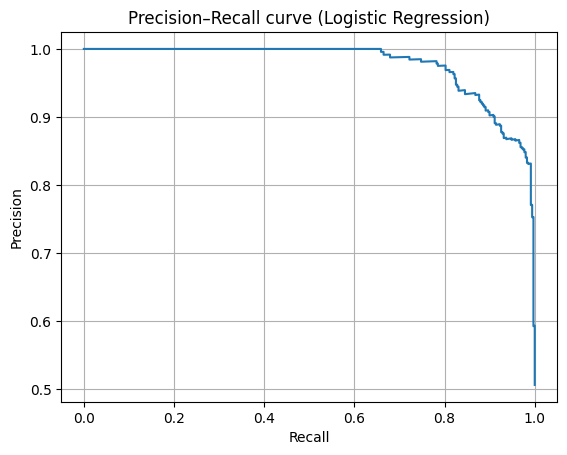

In [18]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_valid_proba)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve (Logistic Regression)")
plt.grid(True)
plt.show()

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=5000, solver="lbfgs"))
])

clf.fit(X_train, y_train)

y_valid_proba = clf.predict_proba(X_valid)[:, 1]
roc = roc_auc_score(y_valid, y_valid_proba)
print(f"ROC-AUC базовая модель: {roc:.4f}")

param_grid = {
    "clf__C": [0.01, 0.1, 0.3, 1.0, 3.0, 10.0],
    "clf__class_weight": [None, "balanced"],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"],
}

grid_clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=10000, random_state=42))
])

grid_search = GridSearchCV(
    estimator=grid_clf,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший ROC-AUC (CV): {grid_search.best_score_:.4f}")


best_model = grid_search.best_estimator_
y_valid_proba_best = best_model.predict_proba(X_valid)[:, 1]
roc_auc_best = roc_auc_score(y_valid, y_valid_proba_best)

print(f"ROC-AUC лучшая модель: {roc_auc_best:.4f}")
print(f"Улучшение: {roc_auc_best - roc:.4f}")


final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        **{k.replace('clf__', ''): v for k, v in grid_search.best_params_.items()},
        max_iter=10000,
        random_state=42
    ))
])

final_model.fit(X_full_train, y)


test_proba_final = final_model.predict_proba(X_full_test)[:, 1]
test_pred_final = final_model.predict(X_full_test)


submission_final = pd.DataFrame({'ID': test_features['ID'], 'LoanApproved': test_proba_final})
submission_final.to_csv("submission_lab2_proba_final.csv", index=False)
print("Файл submission_lab2_proba_final.csv сохранён")

ROC-AUC базовая модель: 0.9753
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшие параметры: {'clf__C': 10.0, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Лучший ROC-AUC (CV): 0.9775
ROC-AUC лучшая модель: 0.9751
Улучшение: -0.0002
Файл submission_lab2_proba_final.csv сохранён
